# 5. Python Usage

YOLOv8 was reimagined using Python-first principles for the most seamless Python YOLO experience yet. YOLOv8 models can be loaded from a trained checkpoint or created from scratch. Then methods are used to train, val, predict, and export the model. See detailed Python usage examples in the [YOLOv8 Python Docs](https://docs.ultralytics.com/usage/python/).

In [1]:
%pip install ultralytics --quiet
import ultralytics
ultralytics.checks()

%pip install tensorflow==2.13 --quiet

%pip install "onnx>=1.12.0" "onnx2tf>=1.15.4,<=1.17.5" "sng4onnx>=1.0.1" "onnxsim>=0.4.33" "onnx_graphsurgeon>=0.3.26" tflite_support onnxruntime --quiet

Ultralytics YOLOv8.1.29 🚀 Python-3.12.2 torch-2.2.1+cpu CPU (12th Gen Intel Core(TM) i7-12700KF)
Setup complete ✅ (20 CPUs, 31.8 GB RAM, 465.3/934.8 GB disk)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow==2.13 (from versions: 2.16.0rc0, 2.16.1)
ERROR: No matching distribution found for tensorflow==2.13


Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      Traceback (most recent call last):
        File "c:\Users\emilo\ws\DTU\birdie\deep\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
          main()
        File "c:\Users\emilo\ws\DTU\birdie\deep\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "c:\Users\emilo\ws\DTU\birdie\deep\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 118, in get_requires_for_build_wheel
          return hook(config_settings)
                 ^^^^^^^^^^^^^^^^^^^^^
        File "C:\Users\emilo\AppData\Local\Temp\pip-build-env-4at2ds7z\overlay\Lib\site-packages\setuptools\build_meta.py", line 325, 

In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from ultralytics import YOLO


# Load a model
# model = YOLO('yolov8n.yaml')  #yolov build a new model from scratch
model = YOLO('yolov8n-seg.pt')  # load a pretrained model (recommended for training)

# Use the model
# results = model.train(data='coco128.yaml', epochs=3)  # train the model
# results = model.val()  # evaluate model performance on the validation set
# results = model.export(format='onnx')  # export the model to ONNX format

100%|██████████| 6.73M/6.73M [00:00<00:00, 60.5MB/s]


In [3]:
img_path = 'golf_01.png'
# img_url = '/content/_97e610d3-a0dd-432f-922b-7816d9c4f3fa.jpeg'
results = model(img_path)  # predict on an image


FileNotFoundError: /content/golf_on_grass.jpg does not exist

In [ ]:
# Visualize the results
for i, r in enumerate(results):
    # Plot results image
    im_bgr = r.plot()  # BGR-order numpy array
    plt.imshow(im_bgr)
    # im_rgb = Image.fromarray(im_bgr[..., ::-1])  # RGB-order PIL image

    # Show results to screen (in supported environments)
    r.show()

    # Save results to disk
    r.save(filename=f'results{i}.jpg')

# modify the network to only predict golfball

Should be this layer:

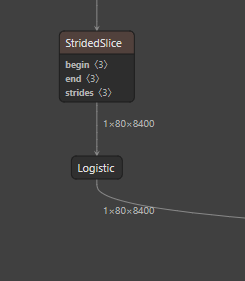

In [ ]:
results[0].masks.xy[0][:,0]

In [ ]:
plt.imshow(im_bgr)
plt.plot(results[0].masks.xy[0][:,0],results[0].masks.xy[0][:,1])

In [ ]:
model.export(format='tflite',int8=True)

# Load the .tflite model and use it for inference:


In [ ]:
%pip install tflite-runtime --quiet

In [ ]:
import tflite_runtime.interpreter as tflite
import matplotlib.pyplot as plt
import cv2
import numpy as np
# interpreter = tflite.Interpreter(model_path='yolov8n-seg_saved_model/yolov8n-seg_float32.tflite')
# interpreter = tflite.Interpreter(model_path='/content/yolov8n-seg_saved_model/yolov8n-seg_int8.tflite')
interpreter = tflite.Interpreter(model_path='/content/yolov8n-seg_int8.tflite')

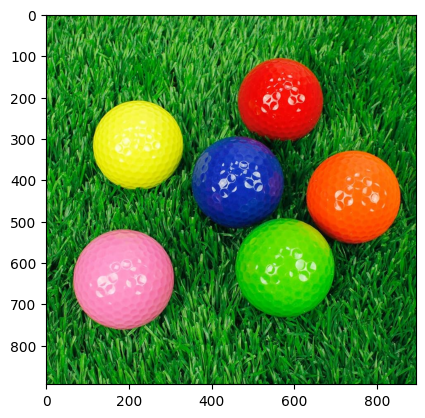

In [ ]:
img = cv2.imread('/content/golf_on_grass.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


In [ ]:

resized_img = cv2.resize(img, (640, 640))
# Add an extra dimension to simulate the batch size
reshaped_img = np.expand_dims(resized_img, axis=0)
reshaped_img = reshaped_img / 255.0


In [ ]:
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']

# input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], reshaped_img.astype(np.float32))

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
mask_data = interpreter.get_tensor(output_details[1]['index'])
# print(output_data)


For output0, 2184 are number of all the boxes predicted by the model.
Each box gives 116 values, consists of (xc, yc, width, height) (4 values), 80 class confidences and 32 mask weights. (4 + 80 + 32 = 116).
The 32 masks in output1 are not the final masks, they are actually just prototype masks (for more info, refer to YOLACT, https://openaccess.thecvf.com/content_ICCV_2019/papers/Bolya_YOLACT_Real-Time_Instance_Segmentation_ICCV_2019_paper.pdf).

Apply NMS on the boxes to get only the few boxes you are looking for, say, above 0.5 class confidences.

To get the final mask of a certain box, multiply each mask with its mask weights and sum them together.



In [ ]:
output_data[0,0:4,0]

array([0.0075486 , 0.00964094, 0.01459601, 0.01984455], dtype=float32)

In [ ]:
output_data[0,3:5,0]

array([1.98445544e-02, 1.36571725e-05], dtype=float32)

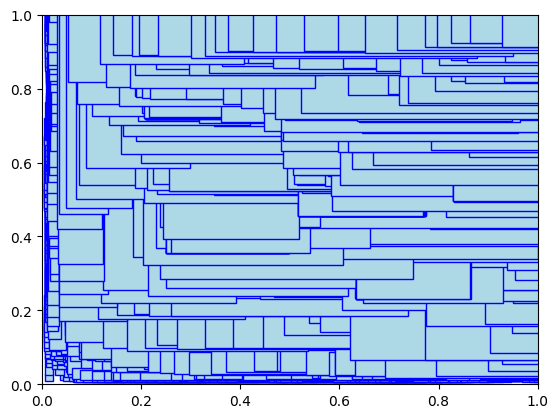

In [ ]:
import matplotlib.patches as patches

# Create a figure and an axis
fig, ax = plt.subplots()

for idx in range(output_data.shape[2]):
  xc,yc,width,height = output_data[0,0:4,idx]
  class_confidences = output_data[0,4:84,idx]
  mask_coefficients = output_data[0,84:116,idx]

  # Create a square patch
  square = patches.Rectangle((xc, yc), width, height, edgecolor='blue', facecolor='lightblue')

  # Add the square patch to the axes
  ax.add_patch(square)

# Display the plot
plt.show()


In [ ]:
print(xc,yc)

0.0075486004 0.0096409395


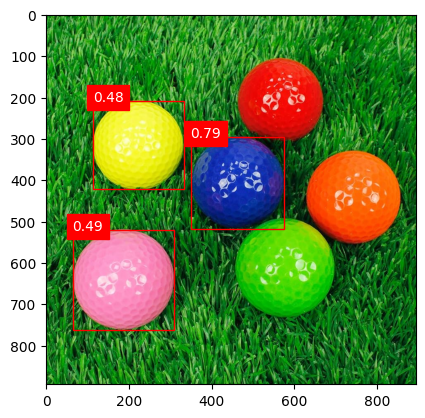

In [ ]:


# Assuming `output_data` is your tensor with bounding box info

# Convert center coordinates to corner coordinates
boxes = []
scores = []
masks = []
for idx in range(output_data.shape[2]):
    xc, yc, width, height = output_data[0, 0:4, idx]
    xmin = xc - width / 2
    ymin = yc - height / 2
    xmax = xc + width / 2
    ymax = yc + height / 2
    boxes.append([xmin, ymin, xmax, ymax])

    # Assuming the maximum class confidence is the score
    class_confidences = output_data[0, 4:84, idx]
    score = np.max(class_confidences)
    scores.append(score)

    mask_coefficients = output_data[0,84:116,idx]
    masks.append(mask_coefficients)

boxes = np.array(boxes)
scores = np.array(scores)
masks = np.array(masks)

# Apply NMS
indices = cv2.dnn.NMSBoxes(boxes.tolist(), scores.tolist(), score_threshold=0.4, nms_threshold=0.4)

# Filter the boxes based on NMS
nms_boxes = boxes[indices[:]]
nms_scores = scores[indices[:]]
nms_masks = masks[indices[:]]

# Plotting
fig, ax = plt.subplots()

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image
ax.imshow(img_rgb)

for box,score in zip(nms_boxes,nms_scores):
    xmin, ymin, xmax, ymax = box*img_rgb.shape[0]
    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(xmin, ymin, f"{score:.2f}", color='white', backgroundcolor='red')




plt.show()


In [ ]:
nms_masks.shape

(4, 32)

In [ ]:
mask_data[0].shape

(160, 160, 32)

In [ ]:
# Assuming `prototype_masks` is your (160, 160, 32) array
# And `mask_coefficients` is your (4, 32) array
prototype_masks = mask_data[0]


# Initialize an empty array to hold the final masks
final_masks = np.zeros((nms_masks.shape[0], prototype_masks.shape[0], prototype_masks.shape[1]))

# Compute the final masks for each instance
for i, coeffs in enumerate(nms_masks):
    # Multiply the prototype masks by the coefficients and sum across the channels
    final_mask = np.tensordot(prototype_masks, coeffs, axes=([2], [0]))
    # Store the computed mask
    final_masks[i] = final_mask

# final_masks now contains the 4 reconstructed masks of shape (160, 160) each

thresholded_masks = final_masks > 0.5  # Example threshold

Hov her kan jeg se at problemet er at maskerne nu har midstet deres placering i billedet. Cropping bør i stedet ske på en måde hvor alt andet end det indefor bb bliver 0

In [ ]:
def crop_mask_by_bbox(mask, bbox, original_img_shape):
    """
    Crop a mask to the region specified by a bounding box and resize it back to the original image shape.

    :param mask: The mask to be cropped, numpy array of shape (160, 160).
    :param bbox: The bounding box with format (xmin, ymin, xmax, ymax).
    :param original_img_shape: The shape of the original image.
    :return: Cropped and resized mask.
    """
    mask_size = final_masks.shape[1]
    mask_shape_preserved = np.zeros_like(mask)

    xmin, ymin, xmax, ymax = (bbox*mask_size).astype(int)

    # Set pixels within the bbox to 1
    mask_shape_preserved[ymin:ymax, xmin:xmax] = 1

    cropped_mask = mask * mask_shape_preserved

    # resized_mask = cv2.resize(cropped_mask, (original_img_shape[1], original_img_shape[0]))
    return cropped_mask

# Assuming `img` is your original image used for prediction
original_img_shape = img.shape

cropped_masks = []
for mask, bbox in zip(thresholded_masks, nms_boxes):
    # Crop and resize the mask
    cropped_mask = crop_mask_by_bbox(mask, bbox, original_img_shape)
    cropped_masks.append(cropped_mask)

# `cropped_masks` now contains the cropped and resized masks


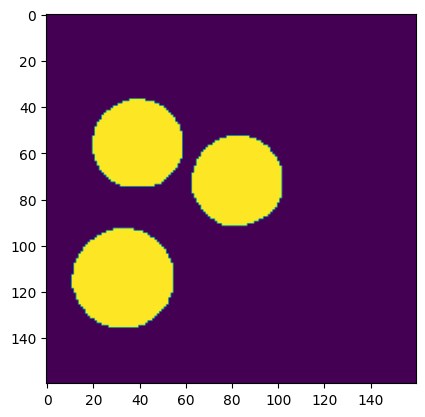

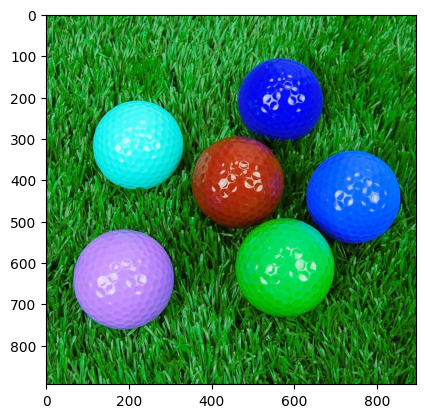

In [ ]:
temp = np.zeros_like(cropped_masks[0])
for mask in cropped_masks:
  temp += mask
plt.imshow(temp)
plt.show()
plt.imshow(img)

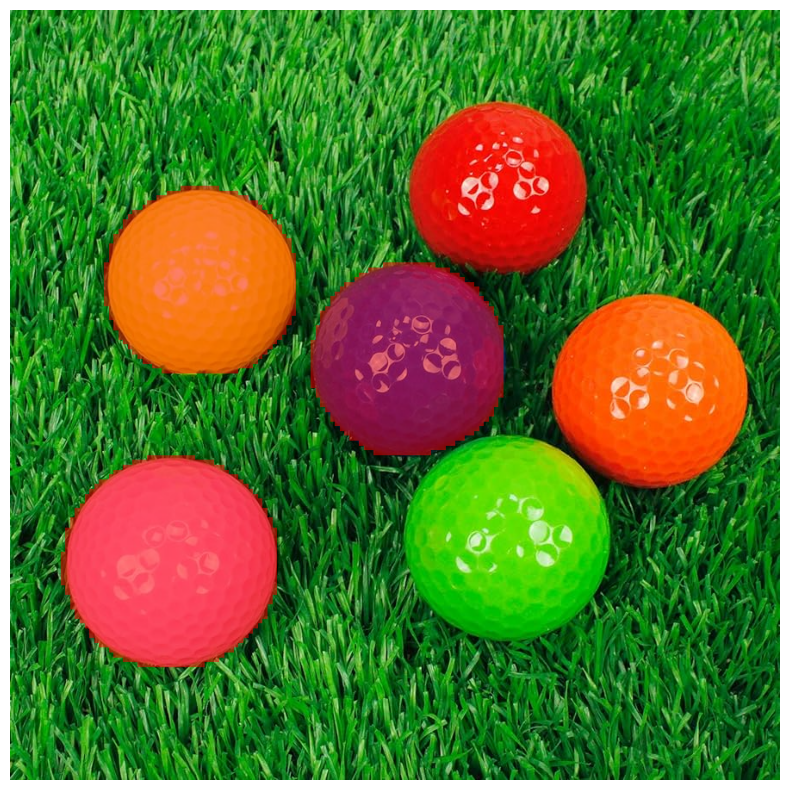

In [ ]:
def overlay_mask_on_image(image, masks, color=(255, 0, 0), alpha=0.5):
    """
    Overlays masks on the original image.

    :param image: Original image in RGB format.
    :param masks: List of masks to overlay, each with shape matching the image's spatial dimensions.
    :param color: Tuple of RGB values to color the mask overlays.
    :param alpha: Transparency level of the masks.
    :return: Image with masks overlaid.
    """


    # Copy the image to avoid modifying the original
    overlay_image = image.copy()
    overlay_image_shape = overlay_image.shape

    for mask in masks:
        # Create an overlay that matches the color and alpha for non-zero mask pixels
        for c in range(3):
            overlay_image[:, :, c] = np.where(mask != 0,
                                              overlay_image[:, :, c] *
                                              (1 - alpha) + alpha * color[c],
                                              overlay_image[:, :, c])

    return overlay_image

original_img_shape = img.shape
resized_masks = [cv2.resize(mask.astype(np.float32), (original_img_shape[1], original_img_shape[0])) for mask in cropped_masks]

# Overlay masks on the image
overlayed_image = overlay_mask_on_image(img_rgb, resized_masks, color=(255, 0, 0), alpha=0.5)

# Plot the result
plt.figure(figsize=(10, 10))
plt.imshow(overlayed_image)
plt.axis('off')  # Hide the axes ticks
plt.show()


# Nice work

Next task i to change the architecture to only have two output classes: background or golf ball. (or maybe all round objects)



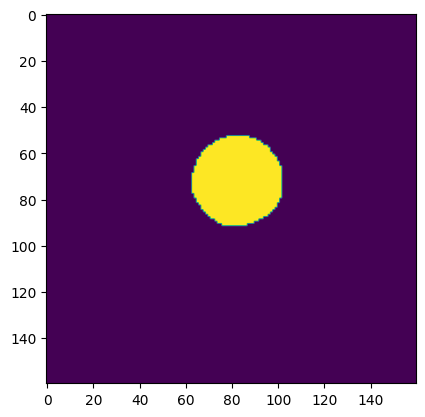

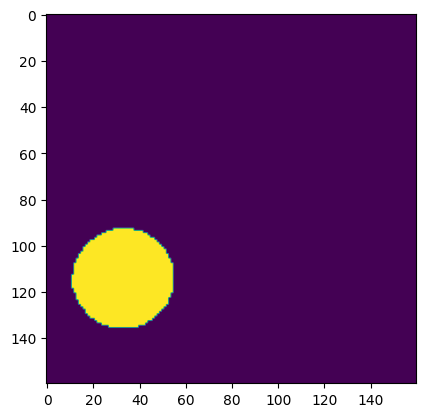

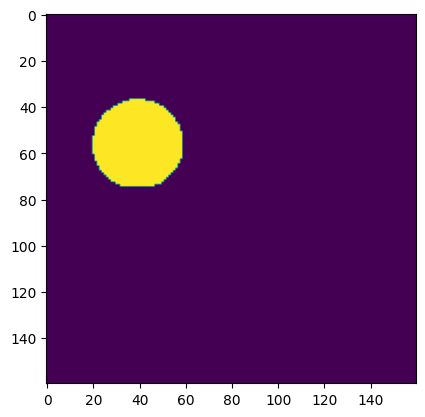

In [ ]:
for mask in cropped_masks:
  plt.imshow(mask)
  plt.show()

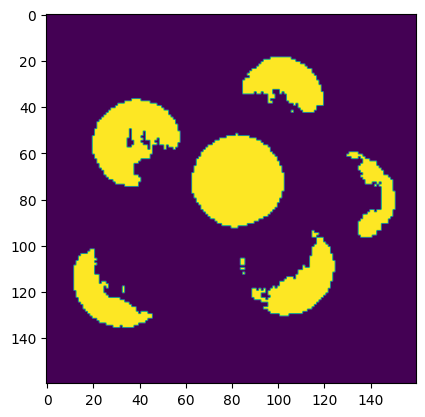

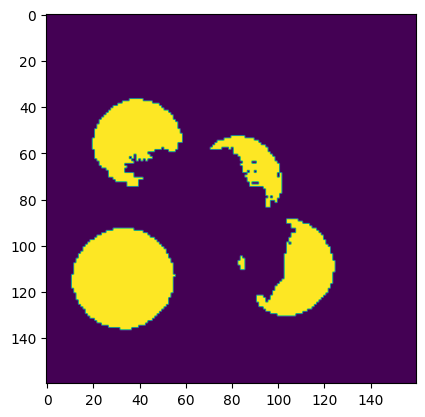

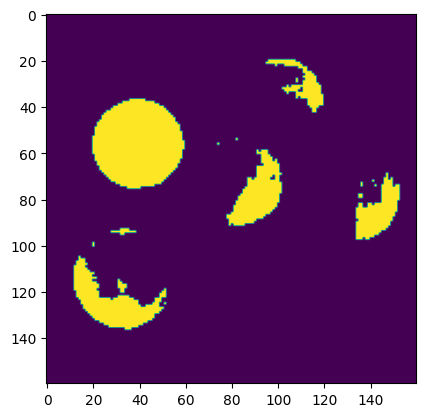

In [ ]:
for mask in thresholded_masks:
  plt.imshow(mask)
  plt.show()

In [ ]:
input_details

[{'name': 'serving_default_images:0',
  'index': 0,
  'shape': array([  1, 640, 640,   3], dtype=int32),
  'shape_signature': array([  1, 640, 640,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [ ]:
output_details

[{'name': 'PartitionedCall:0',
  'index': 478,
  'shape': array([   1,  116, 8400], dtype=int32),
  'shape_signature': array([   1,  116, 8400], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'PartitionedCall:1',
  'index': 431,
  'shape': array([  1, 160, 160,  32], dtype=int32),
  'shape_signature': array([  1, 160, 160,  32], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

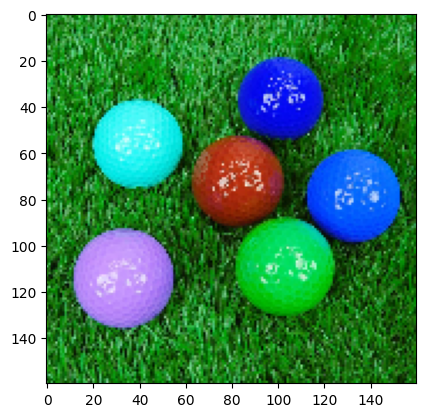

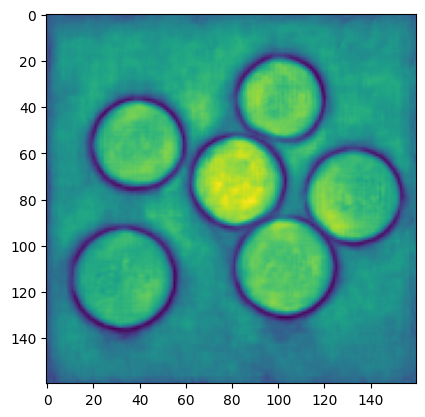

In [ ]:
masks = np.mean(mask_data[0], axis=-1)
plt.imshow(cv2.resize(img, (160, 160)))
plt.show()
plt.imshow(masks)

In [ ]:
threshold = 0.75  # Example threshold
binary_masks = (masks > threshold).astype(np.uint8)
plt.imshow(binary_masks)

In [ ]:
# Sum along the last dimension
np.sum(mask_data[0][:,:,:], axis=-1).shape

In [ ]:
output_data[0,0:3,0:90*90].reshape(3,90,90)

In [ ]:
plt.imshow(output_data[0,0:3,0:90*90].reshape(90,90,3))

In [ ]:
output_data

# 6. Tasks

YOLOv8 can train, val, predict and export models for the most common tasks in vision AI: [Detect](https://docs.ultralytics.com/tasks/detect/), [Segment](https://docs.ultralytics.com/tasks/segment/), [Classify](https://docs.ultralytics.com/tasks/classify/) and [Pose](https://docs.ultralytics.com/tasks/pose/). See [YOLOv8 Tasks Docs](https://docs.ultralytics.com/tasks/) for more information.

<br><img width="1024" src="https://raw.githubusercontent.com/ultralytics/assets/main/im/banner-tasks.png">


## 1. Detection

YOLOv8 _detection_ models have no suffix and are the default YOLOv8 models, i.e. `yolov8n.pt` and are pretrained on COCO. See [Detection Docs](https://docs.ultralytics.com/tasks/detect/) for full details.


In [ ]:
# Load YOLOv8n, train it on COCO128 for 3 epochs and predict an image with it
from ultralytics import YOLO

model = YOLO('yolov8n.pt')  # load a pretrained YOLOv8n detection model
model.train(data='coco128.yaml', epochs=3)  # train the model
model('https://ultralytics.com/images/bus.jpg')  # predict on an image

## 2. Segmentation

YOLOv8 _segmentation_ models use the `-seg` suffix, i.e. `yolov8n-seg.pt` and are pretrained on COCO. See [Segmentation Docs](https://docs.ultralytics.com/tasks/segment/) for full details.


In [ ]:
# Load YOLOv8n-seg, train it on COCO128-seg for 3 epochs and predict an image with it
from ultralytics import YOLO

model = YOLO('yolov8n-seg.pt')  # load a pretrained YOLOv8n segmentation model
model.train(data='coco128-seg.yaml', epochs=3)  # train the model
model('https://ultralytics.com/images/bus.jpg')  # predict on an image

## 3. Classification

YOLOv8 _classification_ models use the `-cls` suffix, i.e. `yolov8n-cls.pt` and are pretrained on ImageNet. See [Classification Docs](https://docs.ultralytics.com/tasks/classify/) for full details.


In [ ]:
# Load YOLOv8n-cls, train it on mnist160 for 3 epochs and predict an image with it
from ultralytics import YOLO

model = YOLO('yolov8n-cls.pt')  # load a pretrained YOLOv8n classification model
model.train(data='mnist160', epochs=3)  # train the model
model('https://ultralytics.com/images/bus.jpg')  # predict on an image

## 4. Pose

YOLOv8 _pose_ models use the `-pose` suffix, i.e. `yolov8n-pose.pt` and are pretrained on COCO Keypoints. See [Pose Docs](https://docs.ultralytics.com/tasks/pose/) for full details.

In [ ]:
# Load YOLOv8n-pose, train it on COCO8-pose for 3 epochs and predict an image with it
from ultralytics import YOLO

model = YOLO('yolov8n-pose.pt')  # load a pretrained YOLOv8n pose model
model.train(data='coco8-pose.yaml', epochs=3)  # train the model
model('https://ultralytics.com/images/bus.jpg')  # predict on an image

## 4. Oriented Bounding Boxes (OBB)

YOLOv8 _OBB_ models use the `-obb` suffix, i.e. `yolov8n-obb.pt` and are pretrained on the DOTA dataset. See [OBB Docs](https://docs.ultralytics.com/tasks/obb/) for full details.

In [ ]:
# Load YOLOv8n-obb, train it on DOTA8 for 3 epochs and predict an image with it
from ultralytics import YOLO

model = YOLO('yolov8n-obb.pt')  # load a pretrained YOLOv8n OBB model
model.train(data='coco8-dota.yaml', epochs=3)  # train the model
model('https://ultralytics.com/images/bus.jpg')  # predict on an image

# Appendix

Additional content below.

In [ ]:
# Pip install from source
!pip install git+https://github.com/ultralytics/ultralytics@main

In [ ]:
# Git clone and run tests on updates branch
!git clone https://github.com/ultralytics/ultralytics -b main
%pip install -qe ultralytics

In [ ]:
# Run tests (Git clone only)
!pytest ultralytics/tests

In [ ]:
# Validate multiple models
for x in 'nsmlx':
  !yolo val model=yolov8{x}.pt data=coco.yaml